In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import sys

import data_preprocess as dp # data_preprocess.py

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Solar Energy Production Forecasting

We are creating a model that can predict solar energy production for every hour of the next day

TODO: 
- [ ] Explore the dataset
- [ ] More than one prediction model
- [ ] Feature engineering 
- [ ] Model interpretation
- [ ] Create short notebook


# Data exploration

- Search domain knowledge 
- Check if the data is intuitive
- Explore individual features
- Explore pairs and groups of features
- Clean up features

## Datapreprocessing

The `data_preprocess()` function performs several operations to prepare datasets for machine learning analysis. First, it verifies if all the required data files exist on disk and then reads these parquet files into Pandas DataFrames. Afterward, it concatenates and merges multiple subsets of data based on location and time, performing some feature engineering like calculating time differences and labeling data as either "observed" or "estimated". Finally, it encodes the 'location' column of the DataFrames into numerical values using LabelEncoder from scikit-learn, and returns two DataFrames: one with features (`X_train`) and another with both features and targets (`X_train_with_targets`).

This is what we have considered in this section:
- Handle Missing Values ( `data_preprocess()`)
- Feature Engineering ( `data_preprocess()`)
- Normalization 

In [32]:
X_train, X_train_with_targets = dp.data_preprocess()
X_train.head()

,date_calc,time,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,...,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location,time_diffs,is_observed
0,2022-10-27 07:00:18,2022-10-28 22:00:00,8.4,1.233,1425.099976,0.0,0.0,1211.699951,1.0,281.399994,...,284.700012,100.0,29429.699219,0.8,-0.4,0.7,-0.0,0,14.995,0
1,2022-10-27 07:00:18,2022-10-28 22:15:00,8.4,1.233,2085.899902,0.0,0.0,1560.500000,1.0,281.299988,...,284.700012,100.0,23604.099609,0.7,-0.4,0.7,-0.0,0,15.245,0
2,2022-10-27 07:00:18,2022-10-28 22:30:00,8.3,1.233,2746.600098,0.0,0.0,1909.400024,1.0,281.200012,...,284.700012,100.0,17799.800781,0.7,-0.3,0.6,-0.0,0,15.495,0
3,2022-10-27 07:00:18,2022-10-28 22:45:00,8.3,1.233,3407.399902,0.0,0.0,2258.199951,1.0,281.200012,...,284.600006,100.0,12016.500000,0.6,-0.2,0.6,-0.0,0,15.745,0
4,2022-10-27 07:00:18,2022-10-28 23:00:00,8.2,1.233,4068.199951,0.0,0.0,2607.000000,1.0,281.100006,...,284.600006,100.0,6254.399902,0.6,-0.1,0.6,-0.0,0,15.995,0


## Feature selection

Here we are going to look further into how to select the best features for our model. Initially we will begin with looking at correleations between the features and the target variable. This with the help of scatterplots, heatmaps and correlation matrices.

### Correlations

We decieded to look closer into the features and their correleations with the target variable `pv_measurement`. 

In [33]:
corr = X_train_with_targets.drop(columns=["time", "date_calc"], inplace=False).corr()
corr["pv_measurement"].sort_values(ascending=False)

pv_measurement                    1.000000
direct_rad:W                      0.615520
direct_rad_1h:J                   0.598611
clear_sky_rad:W                   0.596610
clear_sky_energy_1h:J             0.581296
diffuse_rad:W                     0.521091
diffuse_rad_1h:J                  0.510671
sun_elevation:d                   0.495572
is_day:idx                        0.382365
t_1000hPa:K                       0.273879
dew_point_2m:K                    0.214575
absolute_humidity_2m:gm3          0.212681
pressure_100m:hPa                 0.146773
pressure_50m:hPa                  0.143074
visibility:m                      0.139640
sfc_pressure:hPa                  0.139361
msl_pressure:hPa                  0.129704
ceiling_height_agl:m              0.125216
cloud_base_agl:m                  0.112066
is_observed                       0.058426
wind_speed_w_1000hPa:ms           0.002152
snow_drift:idx                   -0.001738
dew_or_rime:idx                  -0.009610
snow_melt_1

The features where the Corr > |0.1| are the ones we find most interesting. 

#### Positive correlations

Here we can also see that `direct_rad:W`, `direct_rad_1h:J`, `clear_sky_rad:W`,`clear_sky_energy_1h:J`, `diffuse_rad:W`, `diffuse_rad_1h:J` and `sun_elevation:d` are highly correlated with each other. However given the feature name there is not that much information about the feature itself. Therefore we have decieded to look closer into the features and how they effect the power production of the solar panel.

1. **Direct radiation (W)**: This parameter measures the amount of direct sunlight that reaches the ground. Direct radiation is the most effective type of sunlight for solar energy production, so a higher value would generally result in more energy being produced by photovoltaic cells.

2. **Direct radiation 1h (J)**: Similar to direct_rad, this parameter measures the total amount of direct radiation energy within a one-hour period. This could be useful for assessing the potential for solar energy production over short periods of time, especially when direct sunlight is available.

3. **Clear sky radiation (W)**: This measures the solar radiation that would reach the ground under clear sky conditions. This is a theoretical maximum amount of solar radiation, assuming no clouds or other atmospheric interference. It serves as a benchmark to gauge how much energy could be produced under optimal conditions.

4. **Clear sky energy 1h (J)**: This parameter measures the potential energy production under clear sky conditions within a one-hour timeframe. A higher value would indicate more solar energy is available for capture. This would be a direct influence on the solar panel's efficiency, assuming no other environmental issues like dirt or dust on the panels.

5. **Diffuse radiation (W)**: This measures the amount of diffuse radiation, which is sunlight scattered by particles in the atmosphere. Unlike direct sunlight, diffuse radiation comes from all directions. Solar panels can still capture this type of radiation, although typically at a lower efficiency compared to direct sunlight.

6. **Diffuse radiation 1h (W)**: Similar to diffuse_rad, but it measures the total diffuse radiation energy within a one-hour period. This could be useful for understanding the variability in power generation over short periods of time, as diffuse radiation can be influenced by factors like cloud cover and atmospheric conditions.

7. **Sun elevation (d)**: This is the angle of the sun in relation to an observer's horizon. A higher angle (closer to 90 degrees) means the sun is directly overhead, which is generally more favorable for solar energy production. A lower angle means less direct sunlight and thus lower potential for energy generation. This parameter would be particularly important in regions with large changes in sun elevation throughout the year, such as high-latitude areas.

Using these features in a predictive model can help the model to better understand and forecast solar energy production. Each of these four features captures a different aspect of the environmental conditions that influence solar energy capture, and collectively they can provide a comprehensive view of solar energy potential. Understanding how these variables interact and influence solar energy output can be crucial for optimizing the efficiency of solar energy systems.

Therefore we have decieded to create different scatterplots given the features with the highest correlation and the target variable, in order to hopefully see a pattern.

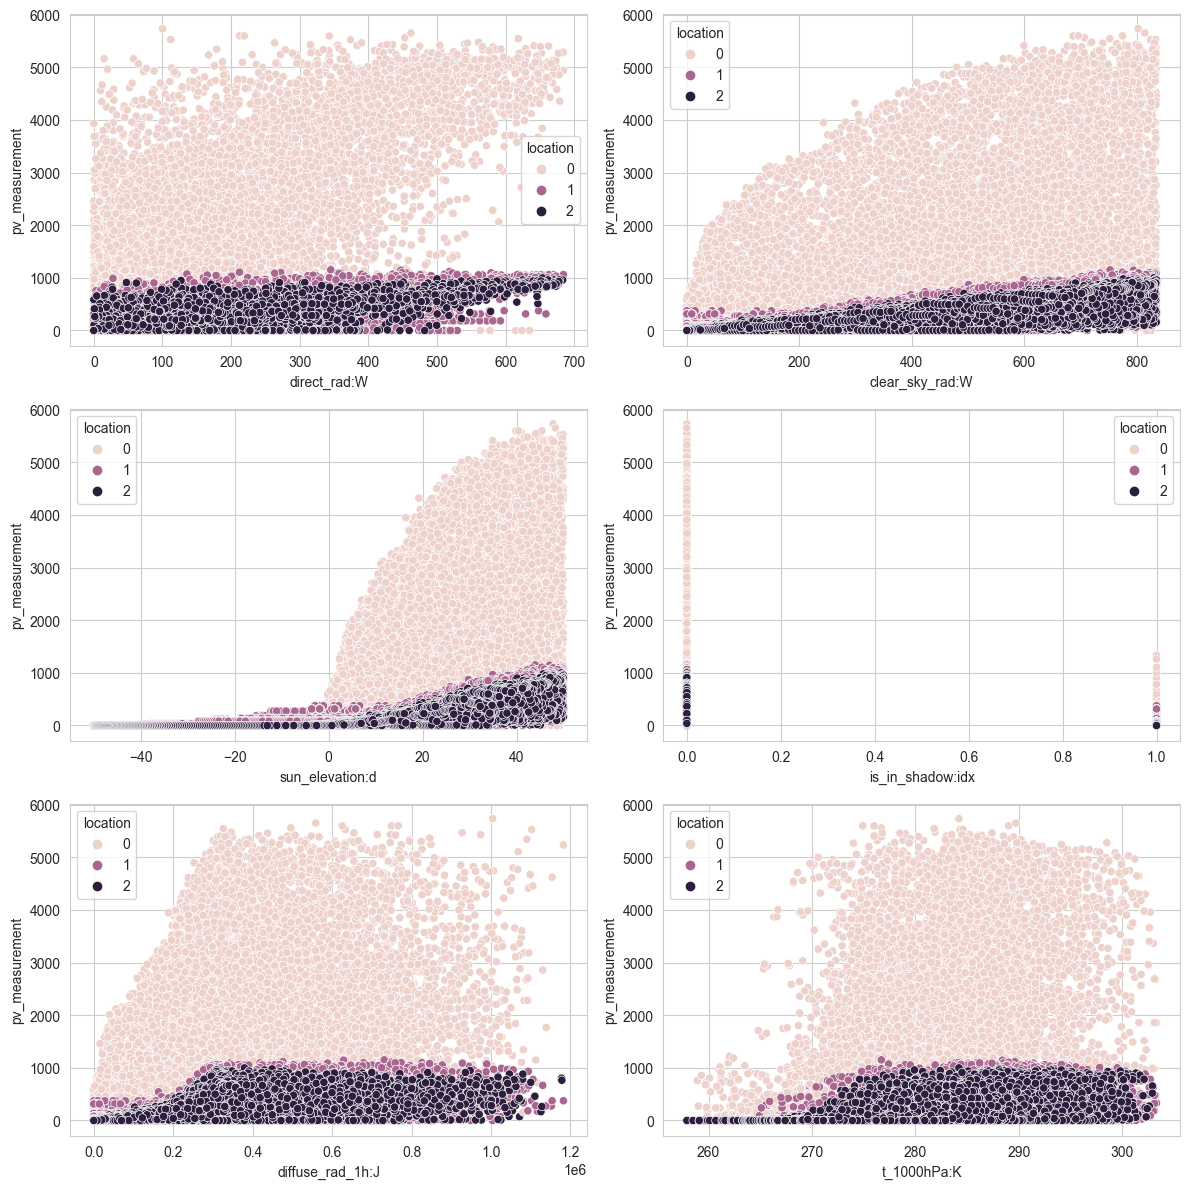

In [35]:
features = ["direct_rad:W", "clear_sky_rad:W", "sun_elevation:d", "is_in_shadow:idx", "diffuse_rad_1h:J", "t_1000hPa:K"] #Note pv_measurement not a feature
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
flat_axes = axes.flatten()
for i, feature in enumerate(features):
    ax = flat_axes[i]
    sns.scatterplot(data=X_train_with_targets, x=feature, y="pv_measurement", hue="location", ax=ax)
plt.tight_layout()
plt.show()

It's difficult to get a complete overview of the data, but we can see that the power production is highly correlated with the direct radiation and the clear sky radiation AND that the location matters. This makes sense, as the power production is dependent on the amount of radiation hitting the solar panel. We can see that location 0 or A is the one with the highest power production in every plot.

#### Negative correlations

Now we want to look closer into the features which are negatively correlated with the target variable:  `relative_humidity_1000hPa:p`, `air_density_2m:kgm3`, `location` and `is_in_shadow:idx`. 

1. **Relative Humidity 1000hPa (p)**: This parameter measures the moisture content in the air at a specific pressure level (1000 hPa). While humidity itself doesn't directly affect the efficiency of solar panels, it can influence cloud formation and atmospheric conditions. High humidity could potentially lead to cloud cover, which would reduce the amount of solar radiation reaching the ground.

2. **Air Density 2m (kg/m³)**: This measures the density of the air 2 meters above the ground. Air density can affect the transmission of sunlight, albeit minimally. Lower air density could mean less scattering and absorption of sunlight, potentially leading to slightly increased solar energy production.

3. **Location**: The geographical location is crucial for solar energy production. It dictates many other factors such as the angle of sunlight, average weather conditions, and duration of daylight. For example, locations closer to the equator generally receive more direct sunlight, increasing the potential for solar energy production.

4. **Is in Shadow (idx)**: This index  indicates whether a location is currently in shadow, perhaps due to buildings, trees, or other obstructions. Being in the shadow would significantly reduce solar radiation reaching the solar panels, thus reducing energy production. This would be an immediate and significant factor affecting solar energy output.

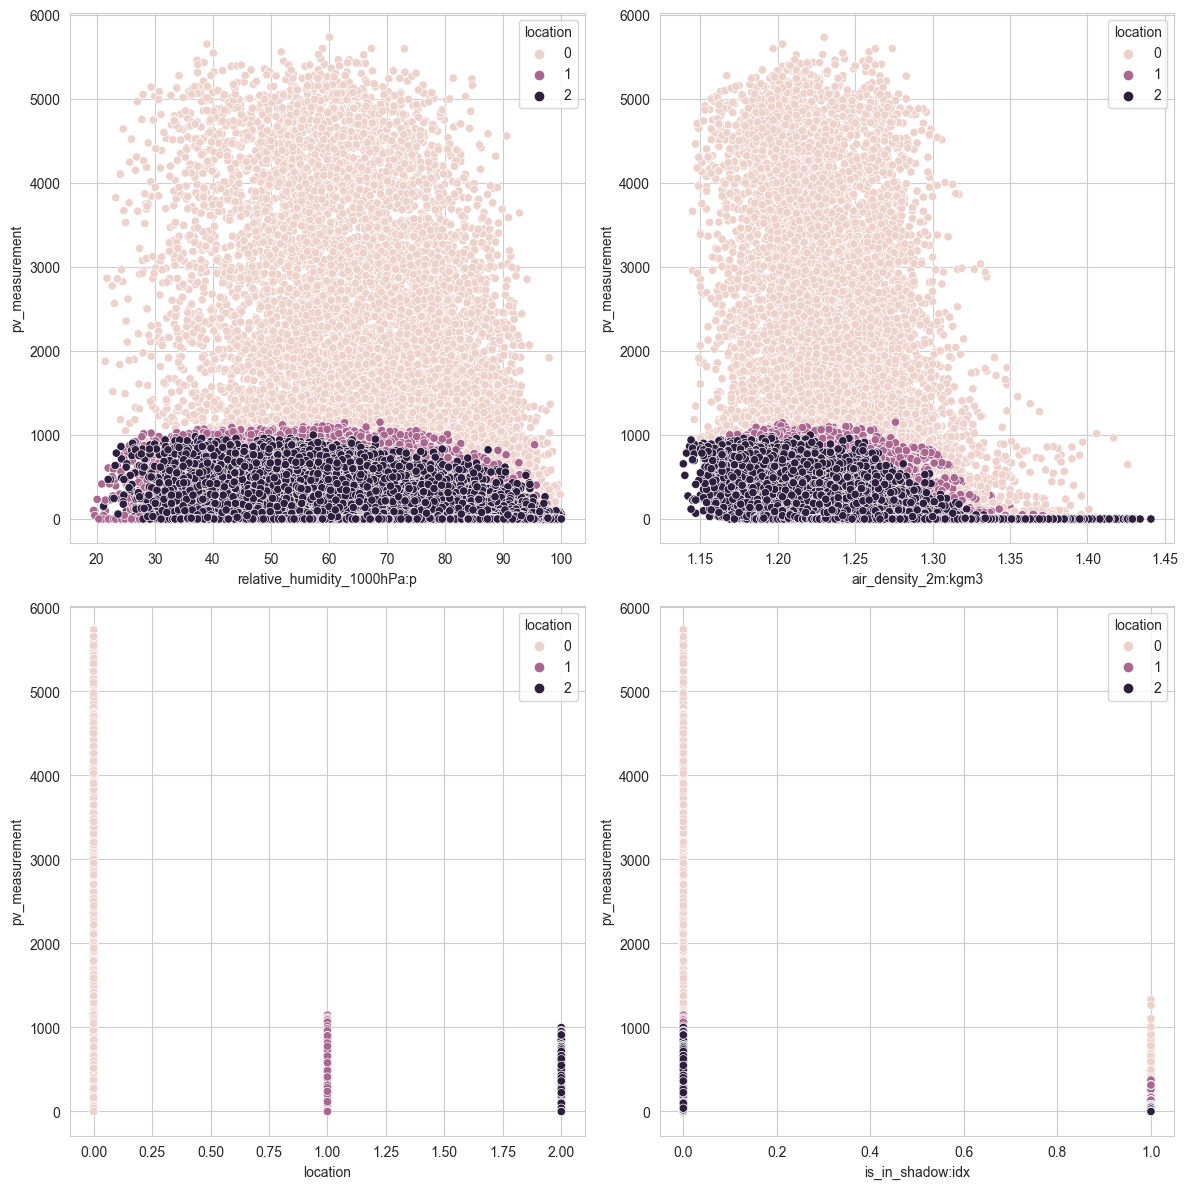

In [ ]:
features = ["relative_humidity_1000hPa:p", "air_density_2m:kgm3", "location", "is_in_shadow:idx"]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
flat_axes = axes.flatten()
for i, feature in enumerate(features):
    ax = flat_axes[i]
    sns.scatterplot(data=X_train_with_targets, x=feature, y="pv_measurement", hue="location", ax=ax)
plt.tight_layout()
plt.show()

None of the negative correlation plots gave any useful information, other than what we saw in the positive correlation plots.

#### Heatmaps

Can be great for showing correlation between multiple variables at once, which means we might see some correlations between other features that we didn't see in the scatterplots.

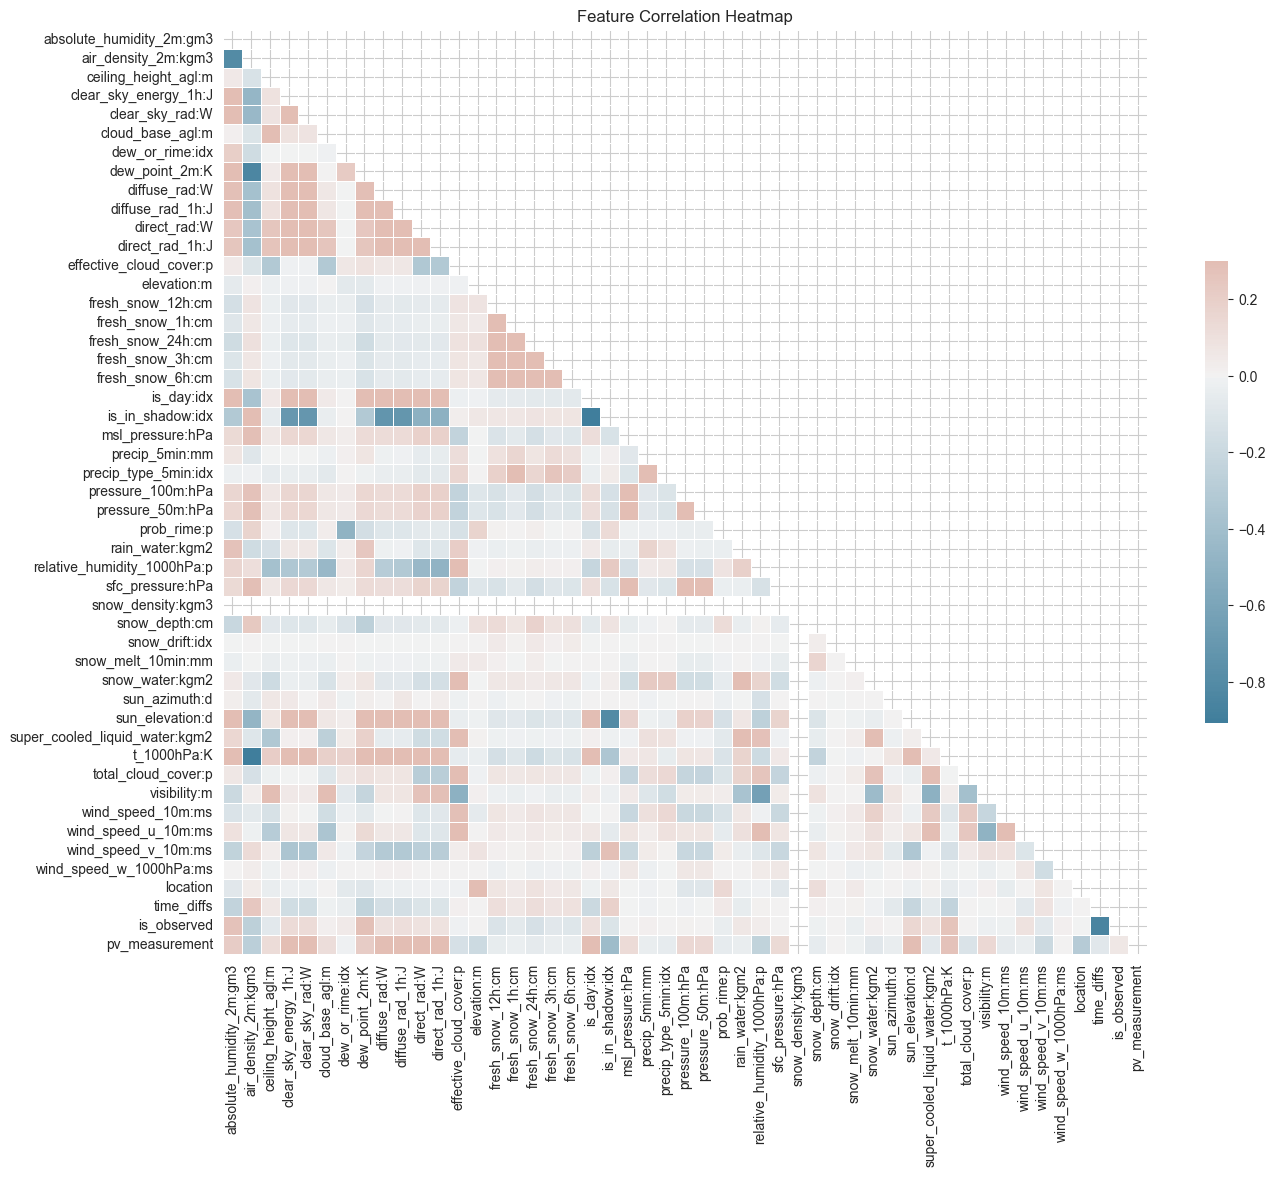

In [ ]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Feature Correlation Heatmap')
plt.show()

In the end we have decieded to move forward with the features which has a correleation of higher than |0.138989|

In [36]:
# Calculate absolute correlations
abs_corr = corr['pv_measurement'].abs()

# Filter by absolute value greater than or equal to 0.138989
features = abs_corr[abs_corr >= 0.138989].index.tolist()

# Remove 'pv_measurement' if it's in the list as it's the target
if 'pv_measurement' in features:
    features.remove('pv_measurement')

print("Filtered features with absolute correlation greater than or equal to 0.138989:", features)
X_train = X_train.loc[:, features]

X_train.info()

Filtered features with absolute correlation greater than or equal to 0.138989: ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m', 'is_day:idx', 'is_in_shadow:idx', 'pressure_100m:hPa', 'pressure_50m:hPa', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'sun_elevation:d', 't_1000hPa:K', 'visibility:m', 'wind_speed_v_10m:ms', 'location']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405151 entries, 0 to 405150
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   absolute_humidity_2m:gm3     405151 non-null  float32
 1   air_density_2m:kgm3          405151 non-null  float32
 2   clear_sky_energy_1h:J        405151 non-null  float32
 3   clear_sky_rad:W              405151 non-null  float32
 4   dew_point_2m

## Prediction model 1 

In [ ]:
## TODO CODE HERE

## Prediction model 2

In [ ]:
## TODO CODE HERE

## Model interpretation

In [ ]:
## TODO CODE HERE